In [1]:
import pandas as pd
import numpy as np
import lbg_forecast.noise as noise
import lbg_forecast.colour_cuts as cuts
import matplotlib.pyplot as plt
import lbg_forecast.utils as utils

In [2]:
run='hpc120'
ngals=200000
nreals = 20
spsp = np.load("./sps_parameter_samples/sps_"+run+".npy")[:nreals,:ngals,:]

In [3]:
phot = np.load("./photo_samples/photo_"+run+".npy")[:nreals,:ngals,:]

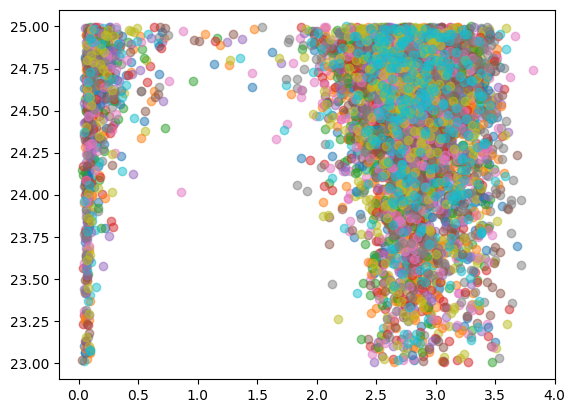

In [4]:
band = 2
for real in range(spsp.shape[0]):
    sps_parameters = spsp[real]
    photometry = phot[real]
    cat = noise.setup_catalog(photometry)
    udrop = noise.select_u_dropouts(cat, 25)
    u_data = noise.pack_dropout_data(udrop, sps_parameters)
    redshifts = noise.unpack_z(u_data)
    magnitudes = noise.unpack_mags(u_data, band)
    mags_all = noise.unpack_mags_all(u_data)
    colours_all = cuts.calculate_colours(mags_all)
    selected_sps,_,inds = cuts.select_dropouts_full('u', [noise.unpack_spsparams(u_data), colours_all])
    selected_redshifts = selected_sps[0][:,0]
    plt.scatter(selected_redshifts, magnitudes[inds], alpha=0.5)

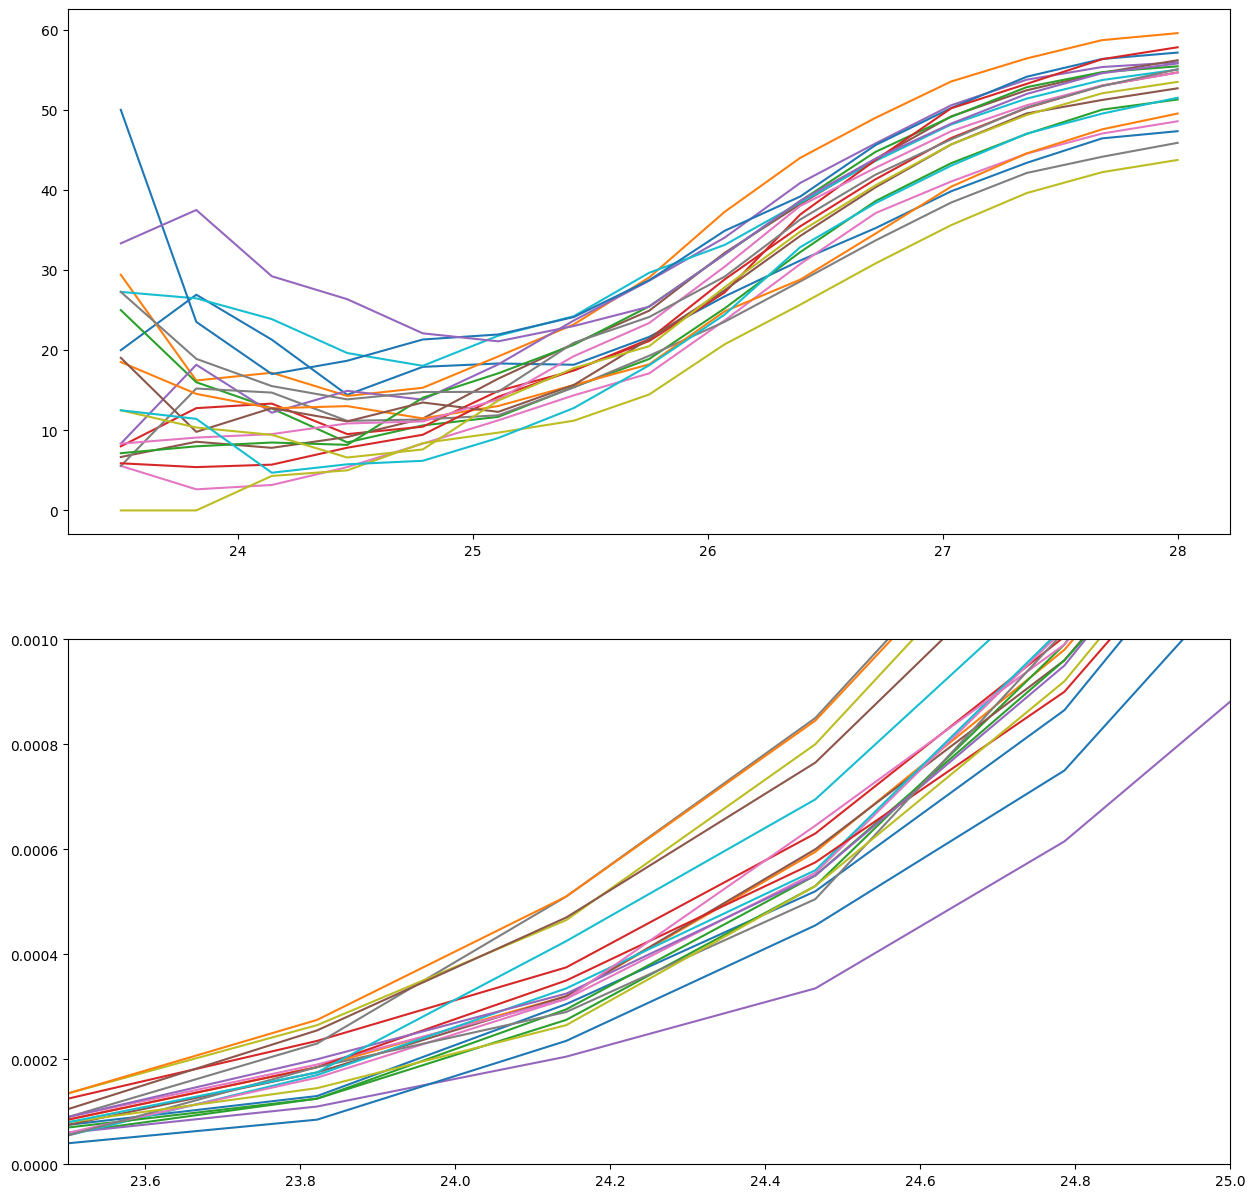

In [5]:
band = 2

f, ax = plt.subplots(2, 1, figsize=(15, 15))

for real in range(spsp.shape[0]):
    sps_parameters = spsp[real]
    photometry = phot[real]
    cat = noise.setup_catalog(photometry)
    fint = []
    depth_list = []
    trans = []
    depths = np.linspace(23.5, 28, 15)
    for depth in depths:
        udrop = noise.select_u_dropouts(cat, depth)
        u_data = noise.pack_dropout_data(udrop, sps_parameters)
        redshifts = noise.unpack_z(u_data)
        magnitudes = noise.unpack_mags(u_data, band)
        mags_all = noise.unpack_mags_all(u_data)
        colours_all = cuts.calculate_colours(mags_all)
        selected_sps,_,inds = cuts.select_dropouts_full('u', [noise.unpack_spsparams(u_data), colours_all])
        selected_redshifts = selected_sps[0][:,0]
        #plt.scatter(selected_redshifts, magnitudes[inds], alpha=0.1)
        fint.append(utils.interlopers(selected_redshifts, 2.0))
        depth_list.append(depth)
        trans.append(len(selected_redshifts)/spsp.shape[1])

    ax[0].plot(depth_list, fint)
    ax[1].plot(depth_list, trans)
    ax[1].set_xlim(23.5, 25)
    ax[1].set_ylim(0, 0.001)

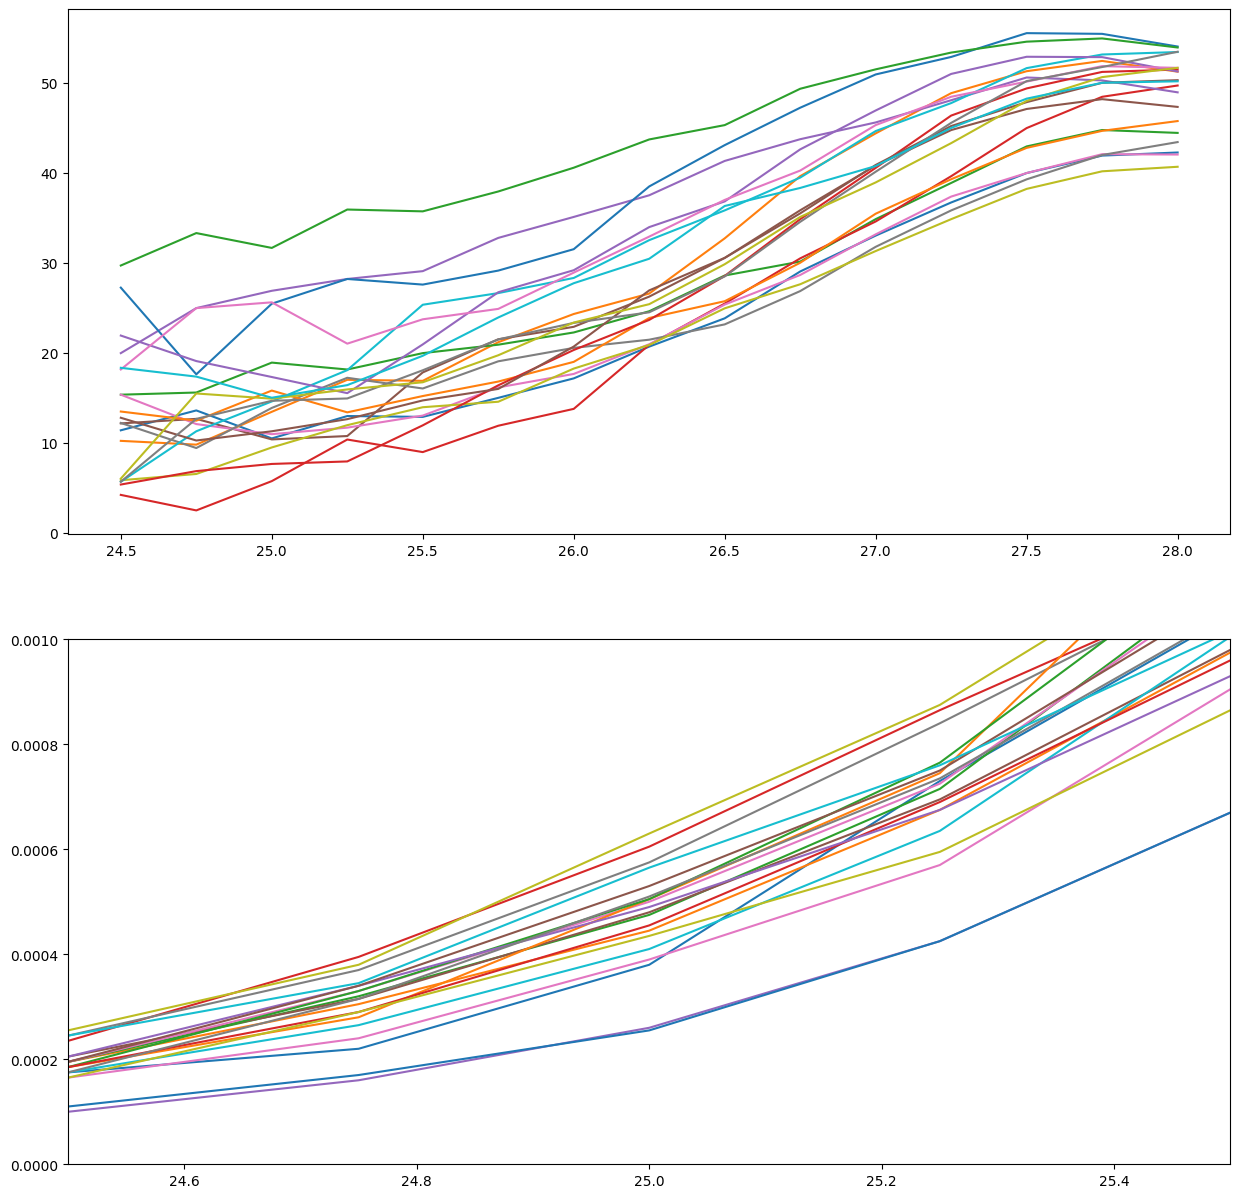

In [6]:
band = 3

f, ax = plt.subplots(2, 1, figsize=(15, 15))

for real in range(spsp.shape[0]):
    sps_parameters = spsp[real]
    photometry = phot[real]
    cat = noise.setup_catalog(photometry)
    fint = []
    depth_list = []
    trans = []
    depths = np.linspace(24.5, 28, 15)
    for depth in depths:
        gdrop = noise.select_g_dropouts(cat, depth)
        g_data = noise.pack_dropout_data(gdrop, sps_parameters)
        redshifts = noise.unpack_z(g_data)
        magnitudes = noise.unpack_mags(g_data, band)
        mags_all = noise.unpack_mags_all(g_data)
        colours_all = cuts.calculate_colours(mags_all)
        selected_sps,_,inds = cuts.select_dropouts_full('g', [noise.unpack_spsparams(g_data), colours_all])
        selected_redshifts = selected_sps[0][:,0]
        #plt.scatter(selected_redshifts, magnitudes[inds], alpha=0.1)
        fint.append(utils.interlopers(selected_redshifts, 2.0))
        depth_list.append(depth)
        trans.append(len(selected_redshifts)/spsp.shape[1])

    ax[0].plot(depth_list, fint)
    ax[1].plot(depth_list, trans)
    ax[1].set_xlim(24.5, 25.5)
    ax[1].set_ylim(0, 0.001)

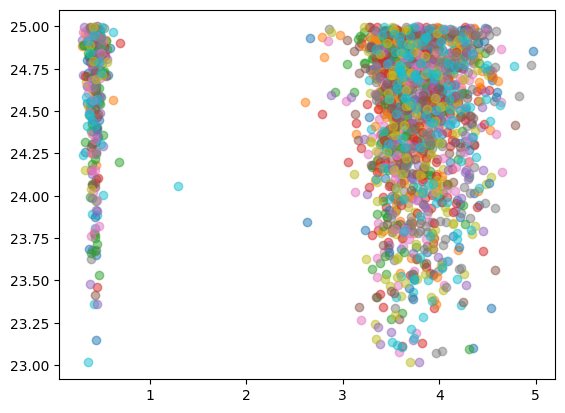

In [7]:
band = 3

for real in range(spsp.shape[0]):
    sps_parameters = spsp[real]
    photometry = phot[real]
    cat = noise.setup_catalog(photometry)
    gdrop = noise.select_g_dropouts(cat, 25)
    g_data = noise.pack_dropout_data(gdrop, sps_parameters)
    redshifts = noise.unpack_z(g_data)
    magnitudes = noise.unpack_mags(g_data, band)
    mags_all = noise.unpack_mags_all(g_data)
    colours_all = cuts.calculate_colours(mags_all)
    selected_sps,_,inds = cuts.select_dropouts_full('g', [noise.unpack_spsparams(g_data), colours_all])
    selected_redshifts = selected_sps[0][:,0]
    plt.scatter(selected_redshifts, magnitudes[inds], alpha=0.5)


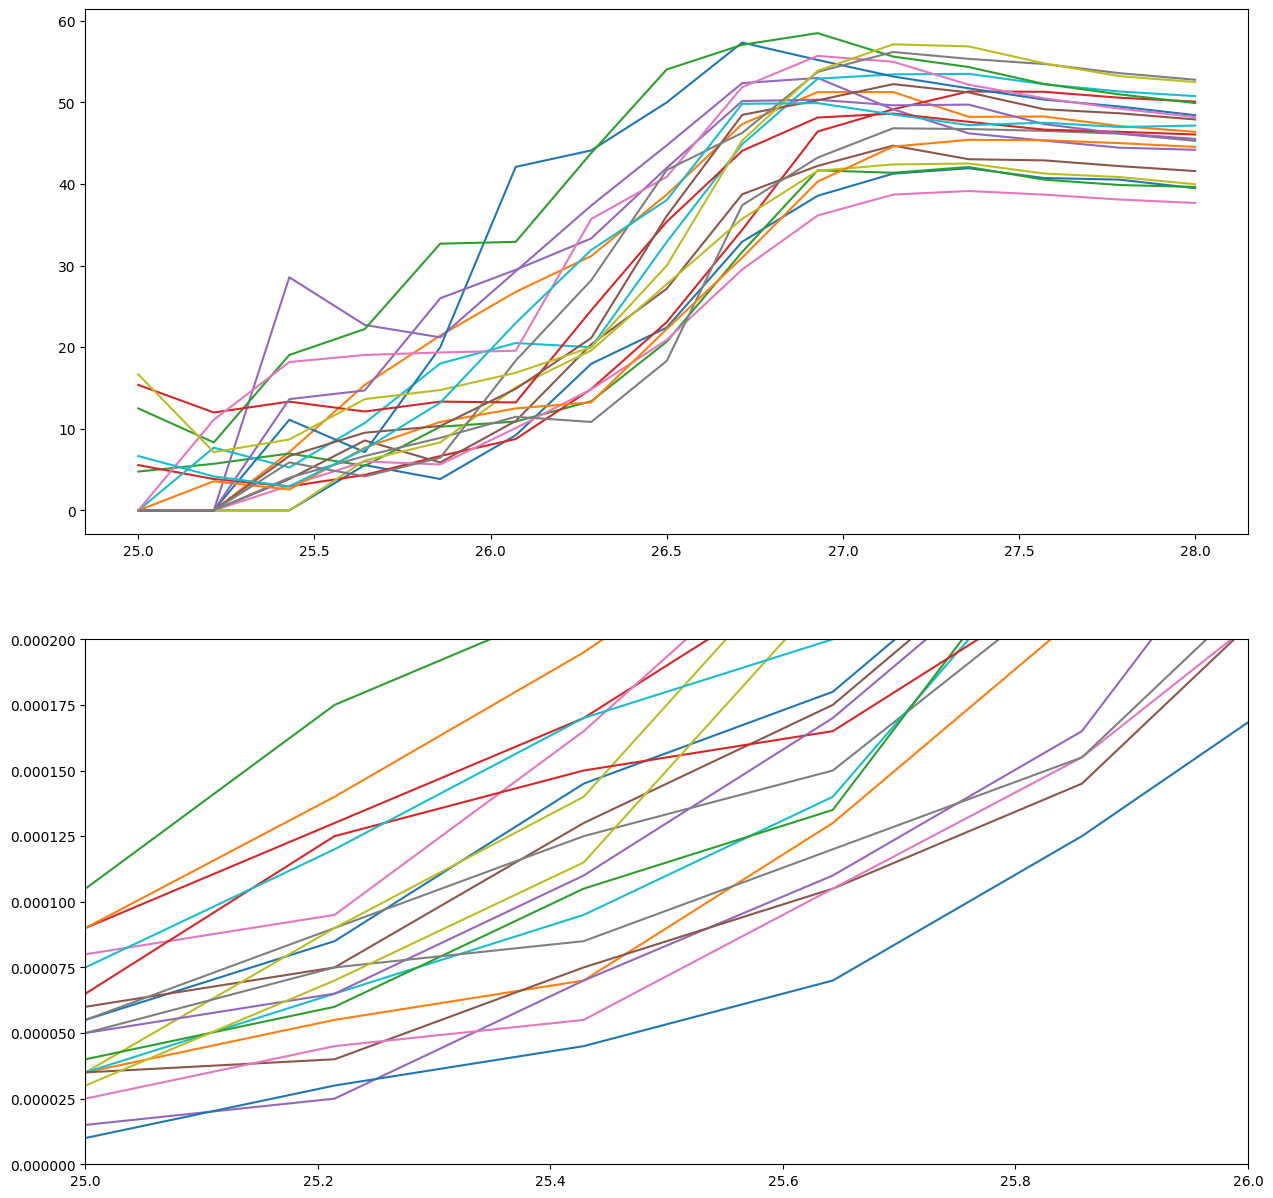

In [8]:
band = 4

f, ax = plt.subplots(2, 1, figsize=(15, 15))

for real in range(spsp.shape[0]):
    sps_parameters = spsp[real]
    photometry = phot[real]
    cat = noise.setup_catalog(photometry)
    fint = []
    depth_list = []
    trans = []
    depths = np.linspace(25, 28, 15)
    for depth in depths:
        rdrop = noise.select_r_dropouts(cat, depth)
        r_data = noise.pack_dropout_data(rdrop, sps_parameters)
        redshifts = noise.unpack_z(r_data)
        magnitudes = noise.unpack_mags(r_data, band)
        mags_all = noise.unpack_mags_all(r_data)
        colours_all = cuts.calculate_colours(mags_all)
        selected_sps,_,inds = cuts.select_dropouts_full('r', [noise.unpack_spsparams(r_data), colours_all])
        selected_redshifts = selected_sps[0][:,0]
        #plt.scatter(selected_redshifts, magnitudes[inds], alpha=0.1)
        fint.append(utils.interlopers(selected_redshifts, 2.0))
        depth_list.append(depth)
        trans.append(len(selected_redshifts)/spsp.shape[1])

    ax[0].plot(depth_list, fint)
    ax[1].plot(depth_list, trans)
    ax[1].set_xlim(25, 26)
    ax[1].set_ylim(0, 0.0002)

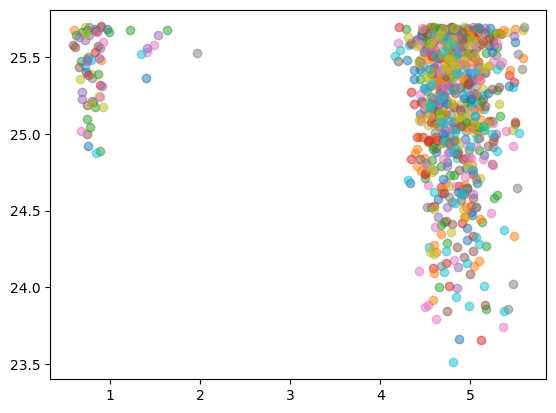

In [9]:
band = 4

for real in range(spsp.shape[0]):
    sps_parameters = spsp[real]
    photometry = phot[real]
    cat = noise.setup_catalog(photometry)
    rdrop = noise.select_r_dropouts(cat, 25.7)
    r_data = noise.pack_dropout_data(rdrop, sps_parameters)
    redshifts = noise.unpack_z(r_data)
    magnitudes = noise.unpack_mags(r_data, band)
    mags_all = noise.unpack_mags_all(r_data)
    colours_all = cuts.calculate_colours(mags_all)
    selected_sps,_,inds = cuts.select_dropouts_full('r', [noise.unpack_spsparams(r_data), colours_all])
    selected_redshifts = selected_sps[0][:,0]
    plt.scatter(selected_redshifts, magnitudes[inds], alpha=0.5)